# REINFORCE for continuous action spaces

In [ ]:
!apt-get install -y xvfb

!pip install gym==0.23.1 \
    pytorch-lightning==1.6 \
    pyvirtualdisplay

!pip install -U brax==0.0.12 jax==0.3.14 jaxlib==0.3.14+cuda11.cudnn82 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


import warnings 
warnings.filterwarnings('ignore')

#### Setup virtual display

In [1]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [1]:
import copy
import torch
import random
import gym
import matplotlib
import functools
import math

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from torch.distributions import Normal

from pytorch_lightning import LightningModule, Trainer

import brax.v1
from brax.v1 import envs
from brax.v1.envs import to_torch
from brax.v1.io import html

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

v = torch.ones(1, device='cuda')

In [25]:
@torch.no_grad()
def plot_policy(policy):
  pos = np.linspace(-4.8, 4.8, 100)
  vel = np.random.random(size=(10000, 1)) * 0.1
  ang = np.linspace(-0.418, 0.418, 100)
  ang_vel = np.random.random(size=(10000, 1)) * 0.1

  g1, g2 = np.meshgrid(pos, ang)
  grid = np.stack((g1,g2), axis=-1)
  grid = grid.reshape(-1, 2)
  grid = np.hstack((grid, vel, ang_vel))

  grid = torch.from_numpy(grid).float()
  loc, _ = policy(grid)

  plot_vals = loc.numpy()
  plot_vals = plot_vals.reshape(100, 100)[::-1]

  plt.figure(figsize=(8, 8))
  plt.imshow(plot_vals, cmap='coolwarm')
  plt.colorbar()
  plt.clim(-1, 1)
  plt.title("P(left | s)", size=20)
  plt.xlabel("Cart Position", size=14)
  plt.ylabel("Pole angle", size=14)
  plt.xticks(ticks=[0, 50, 100], labels=['-4.8', '0', '4.8'])
  plt.yticks(ticks=[100, 50, 0], labels=['-0.418', '0', '0.418'])


@torch.no_grad()
def create_video(env, episode_length, policy=None):
  qp_array = []
  state = env.reset()
  for i in range(episode_length):
    if policy:
      loc, scale = policy(state)
      sample = torch.normal(loc, scale)
      action = torch.tanh(sample)
    else:
      action = env.action_space.sample()
    state, _, _, _ = env.step(action)
    qp_array.append(env.unwrapped._state.qp)
  return HTML(html.render(env.unwrapped._env.sys, qp_array))


@torch.no_grad()
def test_agent(env, episode_length, policy, episodes=10):
  ep_returns = []
  for ep in range(episodes):
    state = env.reset()
    done = False
    ep_ret = 0.0

    while not done:
      loc, scale = policy(state)
      sample = torch.normal(loc, scale)
      action = torch.tanh(sample)   
      state, reward, done, info = env.step(action)
      ep_ret += reward.item()

    ep_returns.append(ep_ret)

  return sum(ep_returns) / episodes  

#### Create the policy

In [7]:
class GradientPolicy(nn.Module):

  def __init__(self, in_features, out_dims, hidden_size=128):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc_mu = nn.Linear(hidden_size, out_dims)
    self.fc_std = nn.Linear(hidden_size, out_dims)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    loc = self.fc_mu(x)
    #in the robotics environment that we are going to solve, the possible actions have been normalized to [-1, 1]
    #that means the maximal force in one direction will be -1 and maximal force in opposite direction will be -1
    #so we have to make sure that the mean of our normal distribution is between -1 and +1
    loc = torch.tanh(loc)
    scale = self.fc_std(x)
    #standard deviation is also known as scale of the distribution
    #standard deviation can never be negative, it can always be a positive value
    #so we also need a function that can make arbitrary negative values into only positive values
    scale = F.softplus(scale) + 0.001#0.001 ensures that our standard deviation doesn't goes to zero
    return loc, scale

#### Create the environment

In [2]:
#In the previous notebook, we used a wrapping class to normalize the values of the observations and the rewards. This time, since we are going to use robotics environments from another library
#which is brax, we cannot use those normalization wrappers because they are not adapted to these envrionments. So to make things simple, we have copied the code from the gym library where we normalize
#the observations and the rewards and we have adapted to the environments used in this library
class RunningMeanStd:
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = torch.zeros(shape, dtype=torch.float32).to(device)
        self.var = torch.ones(shape, dtype=torch.float32).to(device)
        self.count = epsilon

    def update(self, x):
        batch_mean = torch.mean(x, dim=0)
        batch_var = torch.var(x, dim=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count
        )


def update_mean_var_count_from_moments(
    mean, var, count, batch_mean, batch_var, batch_count
):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + torch.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count


class NormalizeObservation(gym.core.Wrapper):

    def __init__(self, env, epsilon=1e-8):
        super().__init__(env)
        self.num_envs = getattr(env, "num_envs", 1)
        self.obs_rms = RunningMeanStd(shape=self.observation_space.shape[-1])
        self.epsilon = epsilon

    def step(self, action):
        obs, rews, dones, infos = self.env.step(action)
        obs = self.normalize(obs)
        return obs, rews, dones, infos

    def reset(self, **kwargs):
        return_info = kwargs.get("return_info", False)
        if return_info:
            obs, info = self.env.reset(**kwargs)
        else:
            obs = self.env.reset(**kwargs)
        obs = self.normalize(obs)
        if not return_info:
            return obs
        else:
            return obs, info

    def normalize(self, obs):
        self.obs_rms.update(obs)
        return (obs - self.obs_rms.mean) / torch.sqrt(self.obs_rms.var + self.epsilon)


class NormalizeReward(gym.core.Wrapper):

    def __init__(self, env, gamma=0.99, epsilon=1e-8):
        super().__init__(env)
        self.num_envs = getattr(env, "num_envs", 1)
        self.return_rms = RunningMeanStd(shape=())
        self.returns = torch.zeros(self.num_envs).to(device)
        self.gamma = gamma
        self.epsilon = epsilon

    def step(self, action):
        obs, rews, dones, infos = self.env.step(action)
        dones = dones.bool()
        self.returns = self.returns * self.gamma + rews
        rews = self.normalize(rews)
        self.returns[dones] = 0.0
        return obs, rews, dones, infos

    def normalize(self, rews):
        self.return_rms.update(self.returns)
        return rews / torch.sqrt(self.return_rms.var + self.epsilon)

In [3]:
#install the environment that we are going to use from the brax library into gym which is our primary reinforcement learning library
entry_point = functools.partial(envs.create_gym_env, env_name='inverted_pendulum')
gym.register('brax-inverted_pendulum-v0', entry_point=entry_point)

In [4]:
def create_env(env_name, num_envs=256, episode_length=1000):
  env = gym.make(env_name, batch_size=num_envs, episode_length=episode_length)
  env = to_torch.JaxToTorchWrapper(env, device=device)
  env = NormalizeObservation(env)
  env = NormalizeReward(env)
  return env

In [35]:
env = gym.make('brax-inverted_pendulum-v0', episode_length=1000)
env = to_torch.JaxToTorchWrapper(env, device=device)
hello=create_video(env, 1000)

/home/akhters/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/akhters/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/akhters/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'jaxlib.xla_extension.ArrayImpl'>`
  logger.warn(
/home/akhters/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarni

In [36]:
hello

In [9]:
env = create_env('brax-inverted_pendulum-v0', num_envs=1)
obs = env.reset()
print("Num envs: ", obs.shape[0], "Obs dimentions: ", obs.shape[1])

/home/akhters/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (1, 4)
  logger.warn(
/home/akhters/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/akhters/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


Num envs:  1 Obs dimentions:  4


/tmp/ipykernel_6429/2546006466.py:13: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  batch_var = torch.var(x, dim=0)


In [10]:
env.observation_space

Box(-inf, inf, (1, 4), float32)

In [11]:
env.action_space

Box(-1.0, 1.0, (1, 1), float32)

In [12]:
obs, reward, done, info = env.step(env.action_space.sample())

/tmp/ipykernel_6429/2546006466.py:13: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  batch_var = torch.var(x, dim=0)


In [13]:
obs

tensor([[nan, nan, nan, nan]], device='cuda:0')

In [14]:
reward

tensor([nan], device='cuda:0')

In [15]:
done

tensor([False], device='cuda:0')

In [16]:
info

{'first_obs': tensor([[ 0.0000, -0.0013,  0.0000, -0.0041]], device='cuda:0'),
 'first_qp': QP(pos=Array([[[ 0.0000000e+00,  0.0000000e+00,  1.0000000e-01],
         [-3.9983843e-04,  0.0000000e+00,  3.9999974e-01]]], dtype=float32), rot=Array([[[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 9.9999976e-01,  0.0000000e+00, -6.6639751e-04,  0.0000000e+00]]],      dtype=float32), vel=Array([[[0., 0., 0.],
         [0., 0., 0.]]], dtype=float32), ang=Array([[[0.        , 0.        , 0.        ],
         [0.        , 0.00408937, 0.        ]]], dtype=float32)),
 'steps': tensor([1.], device='cuda:0'),
 'truncation': tensor([0.], device='cuda:0')}

In [17]:
info.keys()

dict_keys(['first_obs', 'first_qp', 'steps', 'truncation'])

#### Plot the untrained policy

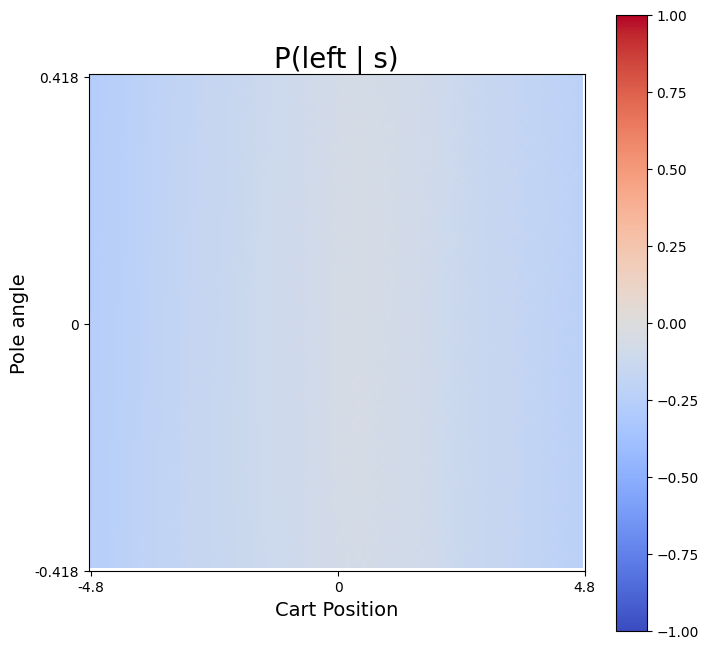

In [18]:
policy = GradientPolicy(4, 1)
grid = plot_policy(policy)

#### Create the dataset

In [19]:
class RLDataset(IterableDataset):

  def __init__(self, env, policy, episode_length, gamma):
    self.env = env
    self.policy = policy
    self.episode_length = episode_length
    self.gamma = gamma
    self.obs = self.env.reset()
  
  @torch.no_grad()
  def __iter__(self):
    transitions = []

    for step in range(self.episode_length):
      loc, scale = self.policy(self.obs)#for iteration, we are not sending batch inside the network, we are sending single observations of the correct dimension
      action = torch.normal(loc, scale)#create a normal distribution for that state, and with that distribution, it select a value according to the distribution probability
      next_obs, reward, done, info = self.env.step(action)
      transitions.append((self.obs, action, reward, done))
      self.obs = next_obs
    
    obs_b, action_b, reward_b, done_b = map(torch.stack, zip(*transitions))#the observations are already pytorch tensors

    running_return = torch.zeros(self.env.num_envs, dtype=torch.float32, device=device)
    return_b = torch.zeros_like(reward_b)
    #for understanding the following, refer the notebook of the discrete REINFORCE
    for row in range(self.episode_length - 1, -1, -1):
      running_return = reward_b[row] + ~done_b[row] * self.gamma * running_return
      return_b[row] = running_return
    
    num_samples = self.env.num_envs * self.episode_length
    obs_b = obs_b.view(num_samples, -1)
    action_b = action_b.view(num_samples, -1)
    return_b = return_b.view(num_samples, -1)
    
    idx = list(range(num_samples))
    random.shuffle(idx)

    for i in idx:
      yield obs_b[i], action_b[i], return_b[i]

#### Create the Proximal Policy Optimization algorithm

In [20]:
class reinforce(LightningModule):

  def __init__(self, env_name, num_envs=256, episode_length=1_000, batch_size=1024, 
               hidden_size=64, policy_lr=1e-4, gamma=0.999, entropy_coef=0.0001, optim=AdamW):
    
    super().__init__()

    self.env = create_env(env_name, num_envs=num_envs, episode_length=episode_length)
    test_env = gym.make(env_name, episode_length=episode_length)#test_env for testing purposes
    test_env = to_torch.JaxToTorchWrapper(test_env, device=device)
    self.test_env = NormalizeObservation(test_env)
    self.test_env.obs_rms = self.env.obs_rms#to make sure that this test_env observes the same normalized observations as the other one, we are going to share the normalization metrics

    obs_size = self.env.observation_space.shape[1]
    action_dims = self.env.action_space.shape[1]

    self.policy = GradientPolicy(obs_size, action_dims, hidden_size)
    self.dataset = RLDataset(self.env, self.policy, episode_length, gamma)

    self.save_hyperparameters()
    self.videos = []

  def configure_optimizers(self):
    return self.hparams.optim(self.policy.parameters(), lr=self.hparams.policy_lr)
 
  def train_dataloader(self):
    return DataLoader(dataset=self.dataset, batch_size=self.hparams.batch_size)

  # Training step.
  def training_step(self, batch, batch_idx):
    obs, action, returns = batch

    loc, scale = self.policy(obs)
    dist = Normal(loc, scale)
    
    log_prob = dist.log_prob(action).sum(dim=-1, keepdim=True)#the way of calculating of log_probabilities is different now, we are calling .log_prob method on the actions takens
    #I can't understand, why the .sum() method? we need log of the probability of only the action which was actually taken according to the policy

    policy_loss = - log_prob * returns
#     The reason for summing the log probabilities across the action dimensions in the line log_prob = dist.log_prob(action).sum(dim=-1, keepdim=True) is related to the nature of the action space and how probabilities are computed for multi-dimensional actions.

# Multi-dimensional Actions
# In environments where the action space is multi-dimensional (i.e., the agent can take multiple actions at each step), the probability distribution over actions is typically modeled as a product of independent distributions, one for each action dimension. For instance, if the action space is continuous and 3-dimensional, the policy might output 3 separate means and standard deviations, one for each dimension.

# Probability of Multi-dimensional Actions
# For such multi-dimensional actions, the overall probability of a particular action vector (e.g., 
# [𝑎1,𝑎2,𝑎3])is the product of the probabilities of the individual action components. In terms of log probabilities:
# log𝑃([𝑎1,𝑎2,𝑎3])=log⁡𝑃(𝑎1)+log⁡𝑃(𝑎2)+log⁡𝑃(𝑎3)
# So, to get the log probability of the action vector, you sum the log probabilities of the individual actions. This is why the .sum(dim=-1) operation is used.
# Example with Code
# Let's break down the specific line of code:
    entropy = dist.entropy().sum(dim=-1, keepdim=True)
# dist.log_prob(action): This computes the log probability of each component of the action vector.
# .sum(dim=-1): This sums these log probabilities across the action dimensions, resulting in a single log probability value for the entire action vector.
# keepdim=True: This keeps the reduced dimension in the result, which can be useful for maintaining consistent tensor shapes.
    self.log("episode/Policy Loss", policy_loss.mean())
    self.log("episode/Entropy", entropy.mean())
    
    return torch.mean(policy_loss - self.hparams.entropy_coef * entropy)

  def on_train_epoch_end(self):
    if self.current_epoch % 10 == 0:
      average_return = test_agent(self.test_env, self.hparams.episode_length, self.policy, episodes=1)
      self.log("episode/Average Return", average_return)

    if self.current_epoch % 50 == 0:
      video = create_video(self.test_env, self.hparams.episode_length, policy=self.policy)
      self.videos.append(video)

#### Purge logs and run the visualization tool (Tensorboard)

In [ ]:
# Start tensorboard.
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

#### Train the policy

In [22]:
algo = reinforce('brax-inverted_pendulum-v0')

trainer = Trainer(
    # gpus=num_gpus,
    max_epochs=101,
    log_every_n_steps=1)

trainer.fit(algo)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-07-07 21:53:56.589844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type           | Params | Mode 
--------------------------------------------------
0 | policy | GradientPolicy | 4.6 K  | train
--------------------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)
/home/akhters/.local

Training: |          | 0/? [00:00<?, ?it/s]

/home/akhters/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/akhters/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/akhters/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'jaxlib.xla_extension.ArrayImpl'>`
  logger.warn(
`Trainer.fit` stopped: `max_epochs=101` reached.


In [47]:
algo.videos[0]